In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Load data and look around

In [2]:
products = pd.read_csv("data/product.csv")

In [3]:
products.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [4]:
products.DEPARTMENT.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [5]:
products.BRAND.unique()

array(['National', 'Private'], dtype=object)

In [6]:
transactions = pd.read_csv("data/transaction_data.csv")

In [7]:
transactions.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


Quoting dataset description:

> The variable sales_value in this table is the amount of dollars received by the retailer on the
sale of the specific product, taking the coupon match and loyalty card discount into account.
It is not the actual price paid by the customer. If a customer uses a coupon, the actual price
paid will be less than the sales_value because the manufacturer issuing the coupon will
reimburse the retailer for the amount of the coupon.

> To calculate the actual product prices, use the formulas below:

> Loyalty card price = (sales_value – (retail_disc + coupon_match_disc))/quantity

> Non-loyalty card price = (sales_value – (coupon_match_disc))/quantity

In [8]:
transactions.WEEK_NO.min(), transactions.WEEK_NO.max()

(1, 102)

We have data from 2 years

In [9]:
household_demographic = pd.read_csv("data/hh_demographic.csv")

In [10]:
household_demographic.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [11]:
def plot_trend(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(10,8))
    
    plt.plot(x, y, label="Actual values")
    
    reg = LinearRegression()
    x_reg = x.to_numpy().reshape(-1, 1)
    reg.fit(x_reg, y)
    plt.plot(x, reg.predict(x_reg), label="Linear trend")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Overall spending of a household in a week

In [12]:
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum()

In [13]:
weekly.head()

household_key  WEEK_NO
1              8          78.66
               10         41.10
               13         26.90
               14         63.43
               15         53.45
Name: SALES_VALUE, dtype: float64

Let's look at average spending in a household over time

In [14]:
avg_weekly = weekly.groupby("WEEK_NO").mean()

In [15]:
avg_weekly = avg_weekly.sort_index()

In [16]:
avg_weekly.head()

WEEK_NO
1    59.217727
2    61.836286
3    59.202632
4    59.133296
5    54.431946
Name: SALES_VALUE, dtype: float64

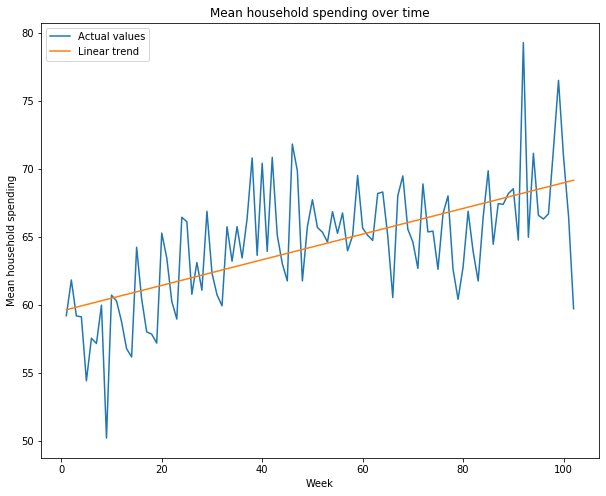

In [17]:
plot_trend(avg_weekly.index, avg_weekly, "Week", "Mean household spending", "Mean household spending over time")

In [18]:
avg_weekly.describe()

count    102.000000
mean      64.409022
std        4.508112
min       50.231785
25%       61.256162
50%       65.026997
75%       66.831610
max       79.266716
Name: SALES_VALUE, dtype: float64

Spending does seem to increase over time overall and there are big fluctuations week-by-week, maybe because people tend to buy stuff at some specific point in time - like at the beginning of the month.

In [19]:
med_weekly = weekly.groupby("WEEK_NO").median()

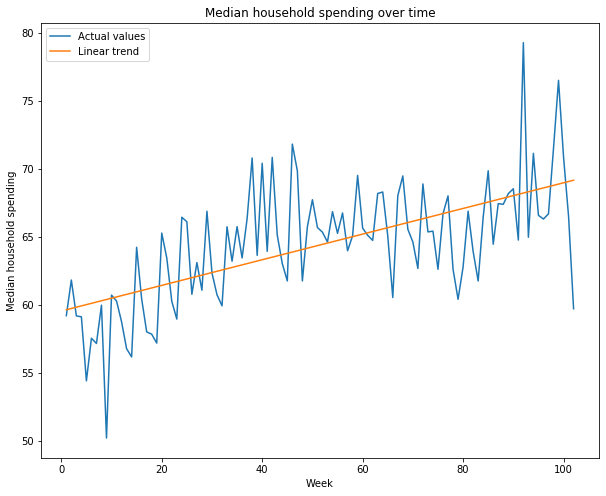

In [20]:
plot_trend(avg_weekly.index, avg_weekly, "Week", "Median household spending", "Median household spending over time")

# Monthly spending

In [21]:
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [22]:
transactions["DAY_OF_MONTH"] = ((transactions["DAY"]) % 30)

In [23]:
monthly = transactions.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum()

In [24]:
monthly = monthly.reset_index()

In [25]:
avg_monthly = monthly.groupby("MONTH")["SALES_VALUE"].mean()

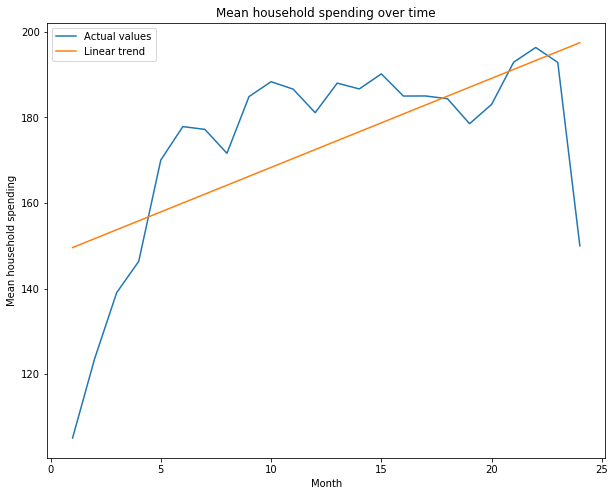

In [26]:
plot_trend(avg_monthly.index, avg_monthly, "Month", "Mean household spending", "Mean household spending over time")

In [27]:
transactions[transactions["MONTH"] == 1]["DAY_OF_MONTH"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [28]:
transactions[transactions["MONTH"] == 23]["DAY_OF_MONTH"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [29]:
transactions[transactions["MONTH"] == 24]["DAY_OF_MONTH"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

The monthly data is far less noisy - has a big growth in the first 5 months, then it reduces pace but overall is still growing, but much more slowly. The big drop at the end is likely due to the fact that the last month is underrepresented - the sales are only up to 20th day.

In [30]:
monthly_cleaned = monthly[monthly["MONTH"] != 24]

In [31]:
avg_monthly = monthly_cleaned.groupby("MONTH")["SALES_VALUE"].mean()

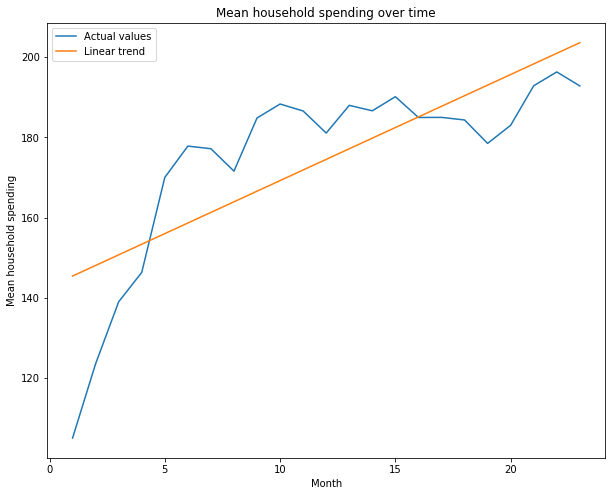

In [32]:
plot_trend(avg_monthly.index, avg_monthly, "Month", "Mean household spending", "Mean household spending over time")

Let's compare it to number of products bought instead of costs.

In [33]:
quantities = transactions.groupby(["household_key", "MONTH"])["QUANTITY"].sum().groupby("MONTH").mean()

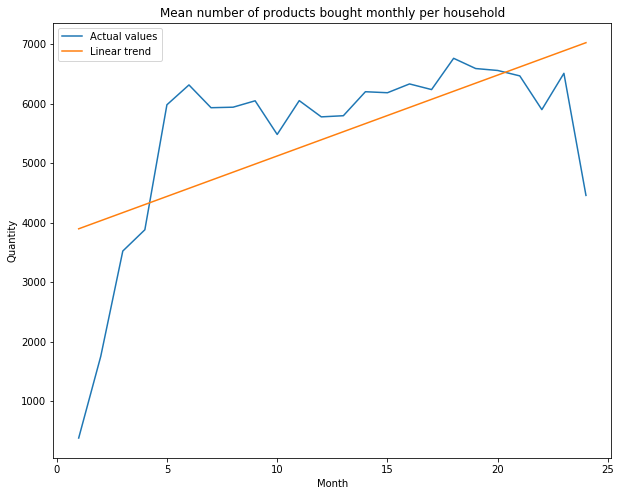

In [34]:
plot_trend(quantities.index, quantities, "Month", "Quantity", "Mean number of products bought monthly per household")

# Are people buying cheaper / more expensive products over time?

In [35]:
transactions["UNIT_PRICE"] = transactions["SALES_VALUE"] / transactions["QUANTITY"] # we deliberately ignore discounts as we want to account the fact that people may specifically want to buy discounted products

In [36]:
counted_transactions = transactions[transactions["QUANTITY"] > 0]

In [37]:
counted_transactions["UNIT_PRICE"].describe()

count    2.581266e+06
mean     2.436950e+00
std      2.720470e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.920000e+00
75%      2.990000e+00
max      4.999900e+02
Name: UNIT_PRICE, dtype: float64

In [38]:
avg_product_price = counted_transactions.groupby(["MONTH"])["UNIT_PRICE"].mean()

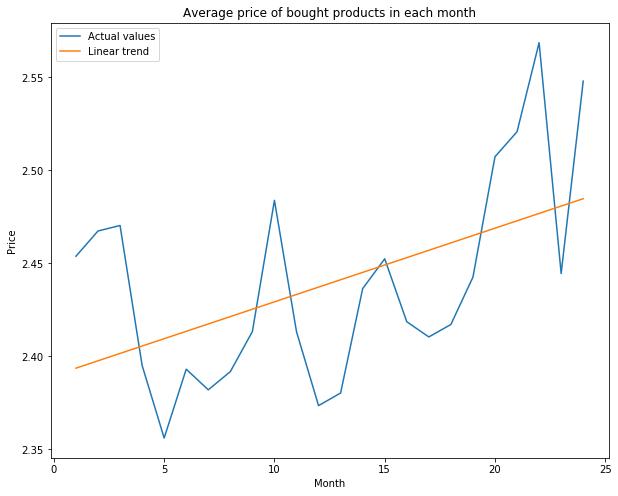

In [39]:
plot_trend(avg_product_price.index, avg_product_price, "Month", "Price", "Average price of bought products in each month")

# Spending on days of month / week

We analyze how days of week are distributed

In [40]:
transactions.groupby("WEEK_NO")["DAY"].unique()

WEEK_NO
1                          [1, 2, 3, 4, 5]
2                 [6, 7, 8, 9, 10, 11, 12]
3             [13, 14, 15, 16, 17, 18, 19]
4             [20, 21, 22, 23, 24, 25, 26]
5             [27, 28, 29, 30, 31, 32, 33]
                      ...                 
98     [678, 679, 680, 681, 682, 683, 684]
99     [685, 686, 687, 688, 689, 690, 691]
100    [692, 693, 694, 695, 696, 697, 698]
101    [699, 700, 701, 702, 703, 704, 705]
102         [706, 707, 708, 709, 710, 711]
Name: DAY, Length: 102, dtype: object

We can see that first and last week are underrepresented, so we will drop them.
The second week starts at 6 so we will devise this to be 1st week day.

Unfortunately we cannot exactly say which day is which weekday, 1st day can be Monday or Sunday probably. We will try to draw hypotheses if possible.

In [41]:
transactions_dow = transactions[(transactions["WEEK_NO"] != 1) & (transactions["WEEK_NO"] != 102)].copy()

In [42]:
(transactions_dow.groupby("WEEK_NO")["DAY"].unique().apply(len) == 7).all()

True

In [43]:
transactions_dow["DAY_OF_WEEK"] = (transactions_dow["DAY"] - 6) % 7 + 1

In [44]:
dow = transactions_dow.groupby(["household_key", "DAY_OF_WEEK"])["SALES_VALUE"].sum().groupby("DAY_OF_WEEK").mean()

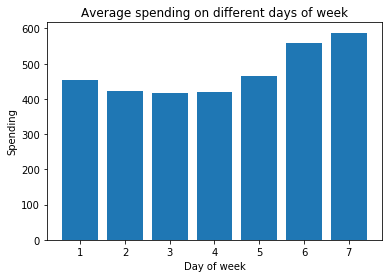

In [45]:
plt.bar(dow.index, dow)
plt.title("Average spending on different days of week")
plt.xlabel("Day of week")
plt.ylabel("Spending")
plt.show()

It is only a hypothesis, but it seems that 1 = Monday indeed, as the last two days get higher spendings and people tend to go shopping on the weekends (at least in countries when most shops are open on Sundays, but if this shop was closed altogether it would have 0 sales or small sales in only specific shopping points, which would be clear from the plot).

So we can conjecture that 1 = Monday, 7 = Sunday and people do most sales on the weekend (which seems reasonable as they have more time) and also a bit more than usual on Friday (after work, maybe in preparation for the weekend) and Mondays (maybe to refill after a weekend).

In [46]:
dom = transactions_dow.groupby(["household_key", "DAY_OF_MONTH"])["SALES_VALUE"].sum().groupby("DAY_OF_MONTH").mean()

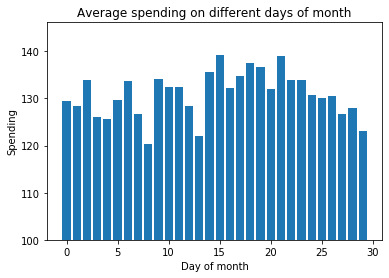

In [47]:
plt.bar(dom.index, dom)
plt.title("Average spending on different days of month")
plt.xlabel("Day of month")
plt.ylabel("Spending")
plt.ylim(100) # I want to see differences clearer thus alter the axis, normally not the best idea
plt.show()

The differences between days of the month don't seem to be very big.

One issue is that we only approximate days of the month as we don't even know if we start in January (although we might try such an assumption). 
But it seems there are no clear trends on spending here (but further research may be done).

# spending in various categories

In [48]:
transactions.MONTH.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [49]:
filtered = transactions[(transactions["MONTH"] != 1) & (transactions["MONTH"] != 24)]

In [50]:
transactions_demographic = filtered.merge(household_demographic, on="household_key")

In [51]:
transactions_demographic.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,MONTH,DAY_OF_MONTH,UNIT_PRICE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,1229,27333842030,30,847270,2,1.00,440,0.0,1621,5,...,2,0,0.50,55-64,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown
1,1229,27333842030,30,869195,1,0.50,440,0.0,1621,5,...,2,0,0.50,55-64,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown
2,1229,27333842030,30,920757,1,2.99,440,0.0,1621,5,...,2,0,2.99,55-64,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown
3,1229,27333842030,30,955025,1,4.99,440,0.0,1621,5,...,2,0,4.99,55-64,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown
4,1229,27333842030,30,1059318,1,1.39,440,-0.2,1621,5,...,2,0,1.39,55-64,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown


Let's see what demographic features we can look at:

In [52]:
sorted(household_demographic.AGE_DESC.unique())

['19-24', '25-34', '35-44', '45-54', '55-64', '65+']

In [53]:
household_demographic.INCOME_DESC.unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [54]:
household_demographic.HOUSEHOLD_SIZE_DESC.unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

In [55]:
household_demographic.HOMEOWNER_DESC.unique()

array(['Homeowner', 'Unknown', 'Renter', 'Probable Renter',
       'Probable Owner'], dtype=object)

In [56]:
def analyze_categories(data, category_column, statistic_computation, sort=True, show_separate=False):
    values = data[category_column].unique()
    if sort:
        values = sorted(values)
    
    def summarize_category(category_name):
        filtered = data[data[category_column] == category_name]
        stat = statistic_computation(filtered)
        return stat
    
    stats = list(map(summarize_category, values))
    
    if show_separate:
        for cat, stat in zip(values, stats):
            print(cat)
            plot_trend(stat.index, stat, "", "", cat)
    
    plt.figure(figsize=(10,8))
    for cat, stat in zip(values, stats):
        plt.plot(stat.index, stat, label=cat)
        #print(stat)
    #plt.xlabel("TODO")
    plt.title("Comparison over " + category_column)
    plt.legend()
    plt.show()

In [57]:
def stat_mean_monthly_spending(data):
    return data.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().groupby("MONTH").mean()

In [58]:
def stat_mean_monthly_quantity(data):
    return data.groupby(["household_key", "MONTH"])["QUANTITY"].sum().groupby("MONTH").mean()

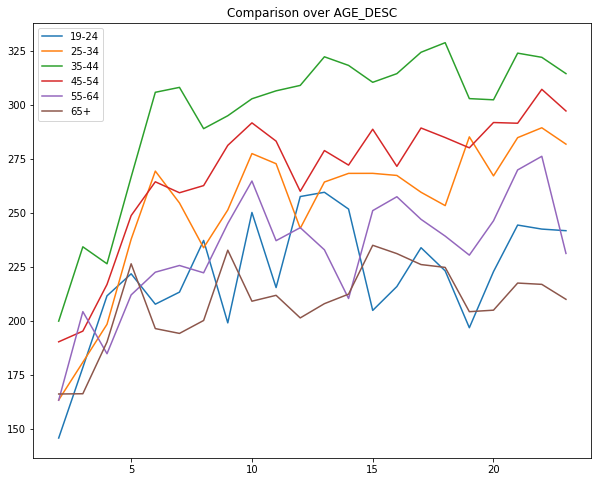

In [59]:
analyze_categories(transactions_demographic, "AGE_DESC", stat_mean_monthly_spending)

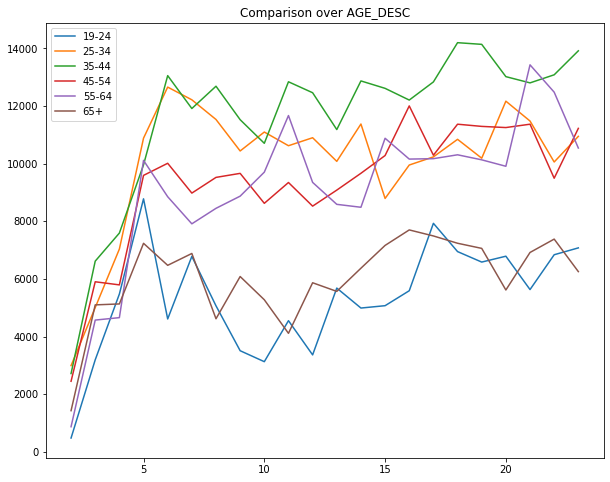

In [60]:
analyze_categories(transactions_demographic, "AGE_DESC", stat_mean_monthly_quantity)

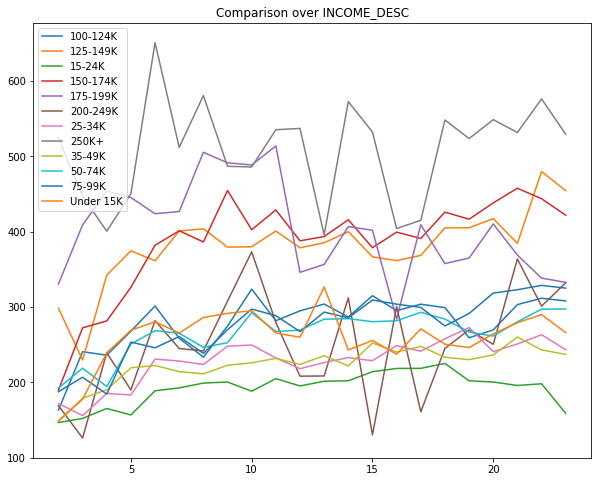

In [61]:
analyze_categories(transactions_demographic, "INCOME_DESC", stat_mean_monthly_spending)

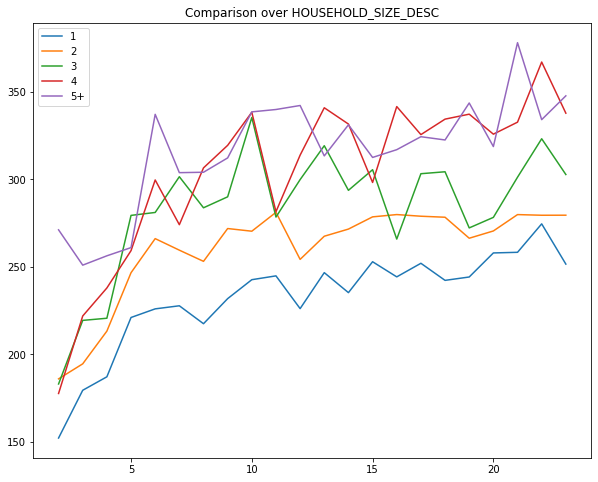

In [62]:
analyze_categories(transactions_demographic, "HOUSEHOLD_SIZE_DESC", stat_mean_monthly_spending)

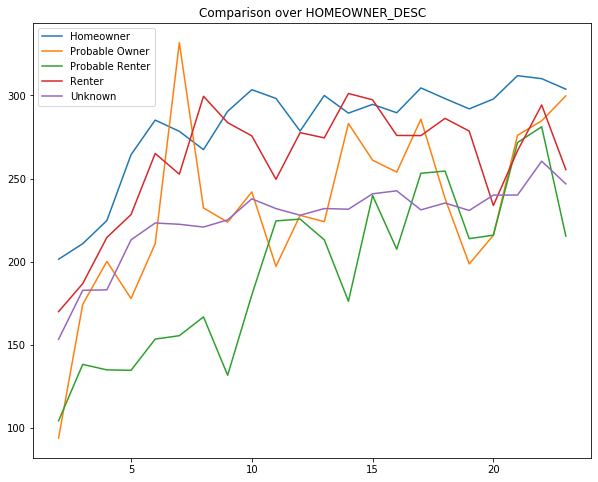

In [63]:
analyze_categories(transactions_demographic, "HOMEOWNER_DESC", stat_mean_monthly_spending)

In [138]:
def find_trend(x, y):
    reg = LinearRegression()
    try:
        x = x.to_numpy()
    except:
        pass # TODO hacky
    x_reg = x.reshape(-1, 1)
    reg.fit(x_reg, y)
    return reg.predict(x_reg)

In [65]:
def analyze_categories_trends(data, category_column, statistic_computation, sort=True, show_separate=True):
    values = data[category_column].unique()
    if sort:
        values = sorted(values)
    
    def summarize_category(category_name):
        filtered = data[data[category_column] == category_name]
        stat = statistic_computation(filtered)
        return stat
    
    stats = list(map(summarize_category, values))
    
    plt.figure(figsize=(10,8))
    for cat, stat in zip(values, stats):
        plt.plot(stat.index, find_trend(stat.index, stat), label=cat)
    #plt.xlabel("TODO")
    plt.title("Comparison over " + category_column)
    plt.legend()
    plt.show()

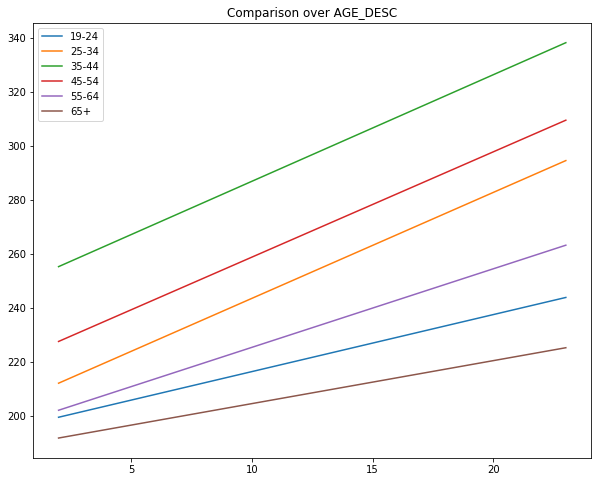

In [66]:
analyze_categories_trends(transactions_demographic, "AGE_DESC", stat_mean_monthly_spending)

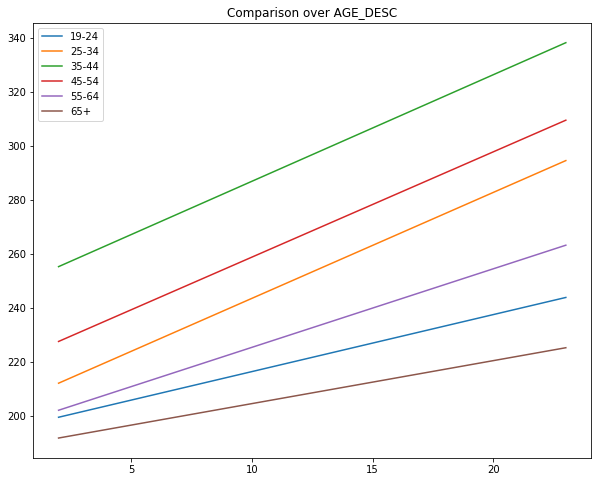

In [67]:
analyze_categories_trends(transactions_demographic, "AGE_DESC", stat_mean_monthly_spending)

# Analyze products bought

In [68]:
filtered = transactions[(transactions["MONTH"] != 1) & (transactions["MONTH"] != 24)]

In [69]:
transactions_products = filtered.merge(products, on="PRODUCT_ID")

In [70]:
transactions_products.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,COUPON_MATCH_DISC,MONTH,DAY_OF_MONTH,UNIT_PRICE,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,1229,27333842030,30,847270,2,1.0,440,0.0,1621,5,...,0.0,2,0,0.5,2,PRODUCE,National,CITRUS,LEMONS,
1,2185,27353061750,33,847270,6,3.0,327,0.0,1710,5,...,0.0,2,3,0.5,2,PRODUCE,National,CITRUS,LEMONS,
2,2374,27353116622,33,847270,2,1.0,381,0.0,1343,5,...,0.0,2,3,0.5,2,PRODUCE,National,CITRUS,LEMONS,
3,1229,27384351944,34,847270,2,1.0,384,0.0,1529,6,...,0.0,2,4,0.5,2,PRODUCE,National,CITRUS,LEMONS,
4,2406,27399425843,36,847270,1,0.5,402,0.0,1236,6,...,0.0,2,6,0.5,2,PRODUCE,National,CITRUS,LEMONS,


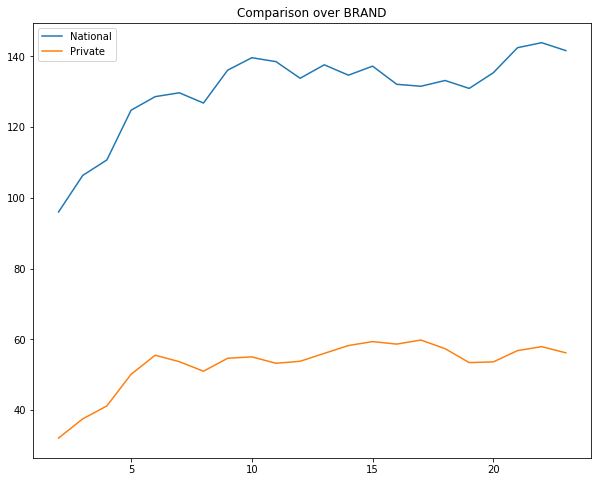

In [71]:
analyze_categories(transactions_products, "BRAND", stat_mean_monthly_spending)

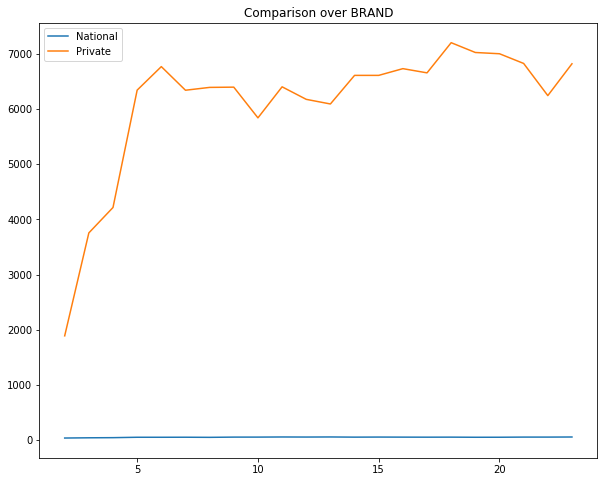

In [72]:
analyze_categories(transactions_products, "BRAND", stat_mean_monthly_quantity)

In [73]:
stat_mean_monthly_quantity(transactions_products[transactions_products["BRAND"] == "Private"])

MONTH
2     1890.424769
3     3755.063202
4     4215.660377
5     6341.487138
6     6767.411255
7     6339.596216
8     6391.010917
9     6395.465637
10    5839.126136
11    6401.395710
12    6174.444204
13    6090.594937
14    6608.662778
15    6608.709557
16    6730.545312
17    6654.323238
18    7200.819489
19    7023.297985
20    7000.434011
21    6824.770270
22    6242.288784
23    6818.690427
Name: QUANTITY, dtype: float64

In [74]:
transactions.QUANTITY.unique()

array([    1,     2,     3, ...,  8859, 21207,  3989])

In [75]:
transactions_products[transactions_products.QUANTITY > 200]["SUB_COMMODITY_DESC"].unique()

array(['GASOLINE-REG UNLEADED'], dtype=object)

<h1 style="color: red">TODO</h1>

# Relative trends

As some groups spend more or less overall, it makes it harder to compare their change of spending, because change from 10 to 20 is much less than from 1000 to 1100, but looking relatively, the first person would be actually spending 2x.

So we will now compute overall spending for each household and analyze monthly spending as a percentage of it.

This way we will see in which months the household spent most relatively and maybe will be able to find some more interesting trends.

In [89]:
overall = transactions_demographic.groupby("household_key")["SALES_VALUE"].sum().rename("overall_spending")

In [90]:
overall

household_key
1        4072.39
7        3055.63
8        5337.62
13      12761.10
16       1506.94
          ...   
2494     1975.64
2496     4339.66
2497     6910.67
2498     2547.44
2499     3091.90
Name: overall_spending, Length: 801, dtype: float64

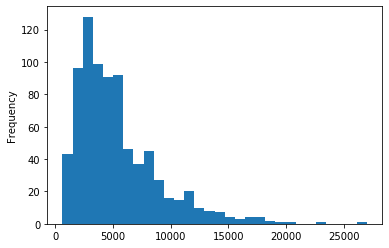

In [91]:
overall.plot.hist(bins=30)

In [101]:
def stat_relative_monthly_spending(data):
    merged = data.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().reset_index().merge(overall, on="household_key")
    merged["relative_spending"] = merged["SALES_VALUE"] / merged["overall_spending"] * 100
    return merged.groupby("MONTH")["relative_spending"].mean()
    # return merged

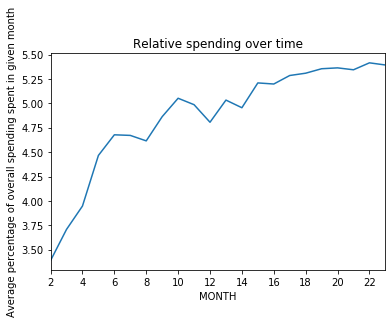

In [113]:
stat_relative_monthly_spending(transactions_demographic).plot()
plt.title("Relative spending over time")
plt.ylabel("Average percentage of overall spending spent in given month")
plt.xticks(range(2,24,2))
plt.show()

In [114]:
relbyage = transactions_demographic.groupby("AGE_DESC").apply(lambda df: stat_relative_monthly_spending(df).to_frame())

In [115]:
relbyage

relative_spending
AGE_DESC MONTH                   
19-24    2               2.525972
         3               4.025557
         4               4.567450
         5               4.829596
         6               4.341692
...                           ...
65+      19              5.546657
         20              5.498872
         21              5.381069
         22              5.203289
         23              5.267852

[132 rows x 1 columns]

In [144]:
def plot_relative_by_category(df, cat):
    months = np.arange(2,24) # a bit hacky
    df = df.groupby(cat).apply(lambda df: stat_relative_monthly_spending(df).to_frame())
    plt.figure(figsize=(10,8))
    def plot_part(part):
        plt.plot(months, part, label=part.name)
    df.groupby(cat).apply(plot_part)
    plt.legend()
    plt.title("Relative spending split by " + cat + " over time")
    plt.xlabel("Month")
    plt.ylabel("Relative spending")
    plt.show()
    
    plt.figure(figsize=(10,8))
    def plot_trend(part):
        plt.plot(months, find_trend(months, part), label=part.name)
    df.groupby(cat).apply(plot_trend)
    plt.legend()
    plt.title("Relative spending trend split by " + cat + " over time")
    plt.xlabel("Month")
    plt.ylabel("Relative spending trend")
    plt.show()

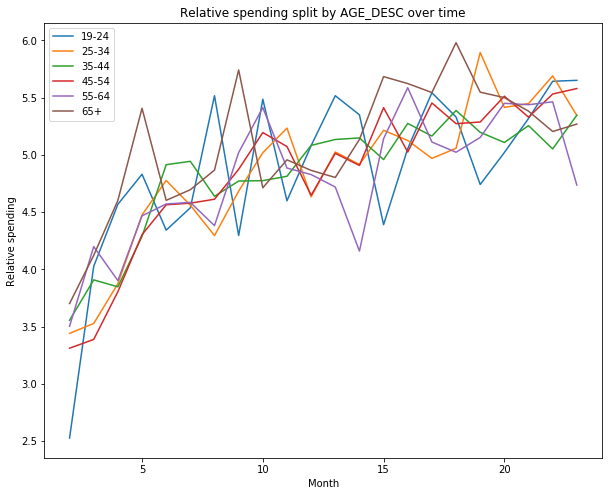

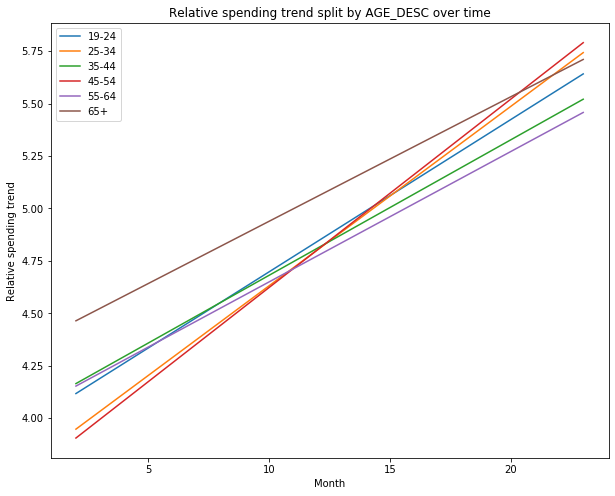

In [145]:
plot_relative_by_category(transactions_demographic, "AGE_DESC")

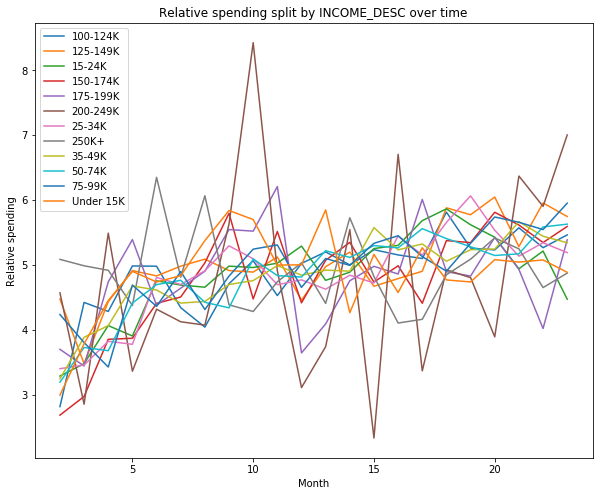

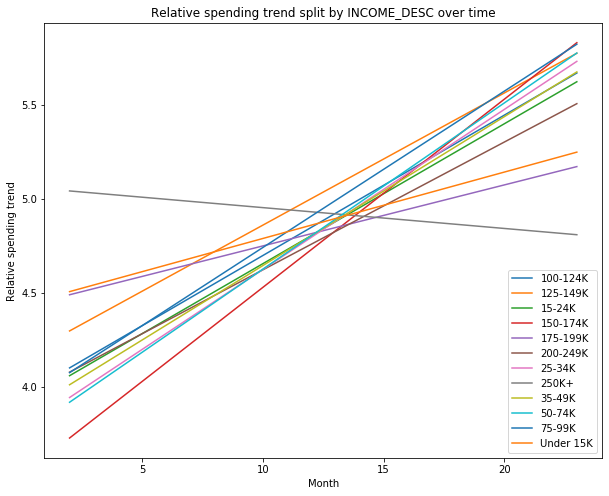

In [146]:
plot_relative_by_category(transactions_demographic, "INCOME_DESC")